In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import seaborn as sns
from xgboost import plot_importance, plot_tree
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
np.random.seed(42)
random.seed(42)
RANDOM_SEED = 42
plt.style.use('fivethirtyeight')
sns.set()

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# First step : Fill missing value in weather by interpolation & greve with Zeros

In [3]:
data = pd.read_csv('../Data/all_in_one.csv')
data.Datetime = pd.to_datetime(data.Datetime)
data.head()

,Datetime,temp,desc,templow,icon,baro,wind,wd,hum,rain,fog,thunder,snow,Année,Mois,Jour,Heure,Jour semaine,Férié,Vacances,confinement_1,confinement_2,confinement_3,curfew,intensite_greve,etat_barre_ce,q_ce,k_ce,etat_barre_lc,q_lc,k_lc,etat_barre_pv,q_pv,k_pv
0,2014-01-01 00:00:00,7.0,Low clouds.,6.0,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,0.0,0.0,2014.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-01 01:00:00,6.0,Low clouds.,6.0,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,0.0,0.0,2014.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.9,3.0,4.0,0.00000,3.0,205.0,2.25945,3.0,486.0,6.17889
2,2014-01-01 02:00:00,6.0,Low clouds.,6.0,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,0.0,0.0,2014.0,1.0,1.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.9,3.0,21.0,0.10445,3.0,283.0,3.25111,3.0,571.0,6.66222
3,2014-01-01 03:00:00,6.0,Low clouds.,6.0,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,0.0,0.0,2014.0,1.0,1.0,3.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.9,3.0,417.0,6.12667,3.0,309.0,3.36000,3.0,532.0,5.56611
4,2014-01-01 04:00:00,6.0,Low clouds.,6.0,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,0.0,0.0,2014.0,1.0,1.0,4.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.9,3.0,1089.0,14.39890,3.0,277.0,3.01445,3.0,458.0,4.63444


In [4]:
data = data[data.Datetime < '2020-12-18']

In [5]:
data.at[data.desc=='No weather data available', ['temp', 'templow', 'icon', 'baro', 'wind', 'wd','hum', 'rain', 'fog', 'thunder', 'snow']] = np.nan
for col in ['temp', 'templow', 'icon', 'baro', 'wind', 'wd','hum', 'rain', 'fog', 'thunder', 'snow']:
    data[col] = data[col].interpolate(method='linear')
data.to_csv('../Data/fillna_big_df.csv', index=False)

# Second Step : Creature Features

## Feature engineering

In [25]:
data = pd.read_csv('../Data/fillna_big_df.csv')
data.Datetime = pd.to_datetime(data.Datetime)
df = copy.deepcopy(data)

### Time Feature 

In [26]:
df['hour'] = df['Datetime'].dt.hour
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['quarter'] = df['Datetime'].dt.quarter
df['month'] = df['Datetime'].dt.month
df['year'] = df['Datetime'].dt.year
df['dayofyear'] = df['Datetime'].dt.dayofyear
df['dayofmonth'] = df['Datetime'].dt.day
df['weekofyear'] = df['Datetime'].dt.weekofyear

<ipython-input-26-3b8f22692917>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Datetime'].dt.weekofyear


#### Hours

In [27]:
df['sin_hour'] = np.sin((2*np.pi/24)*(df.hour))
df['cos_hour'] = np.cos((2*np.pi/24)*(df.hour))
df = df.drop(['hour'], axis=1)

#### Dayofweek

In [28]:
df = pd.concat([df, pd.get_dummies(df['dayofweek'], prefix='dayofweek')], axis=1)
df = df.drop(['dayofweek'], axis=1)

#### Quarter

In [29]:
df = pd.concat([df, pd.get_dummies(df['quarter'], prefix='quarter')], axis=1)
df = df.drop(['quarter'], axis=1)

#### Month

In [30]:
df = pd.concat([df, pd.get_dummies(df['month'], prefix='month')], axis=1)
df = df.drop(['month'], axis=1)

#### Dayofyear

In [31]:
df['sin_dayofyear'] = np.sin((2*np.pi/365.2425)*(df.dayofyear))
df['cos_dayofyear'] = np.cos((2*np.pi/365.2425)*(df.dayofyear))
df = df.drop(['dayofyear'], axis=1)

#### Weekofyear

In [32]:
df['sin_weekofyear'] = np.sin((2*np.pi/53)*(df.weekofyear))
df['cos_weekofyear'] = np.cos((2*np.pi/53)*(df.weekofyear))
df = df.drop(['weekofyear'], axis=1)

#### Dayofmonth

In [33]:
df = pd.concat([df, pd.get_dummies(df['dayofmonth'], prefix='dayofmonth')], axis=1)
df = df.drop(['dayofmonth'], axis=1)

### Weather

#### Wind

In [34]:
# Convert to radian
wd_rad = df.wd*np.pi/180
df['Wx'] = df.wind * np.cos(wd_rad)
df['Wy'] = df.wind * np.sin(wd_rad)
df = df.drop(['wind', 'wd'], axis=1)

### Description

In [35]:
values = df.desc
counts = pd.value_counts(values)
mask = values.isin(counts[counts >= 30].index)
df = pd.concat([df, pd.get_dummies(values[mask], prefix='desc')], axis=1)
df = df.drop(['desc'], axis=1)

In [36]:
df.tail()

,Datetime,temp,templow,icon,baro,hum,rain,fog,thunder,snow,Année,Mois,Jour,Heure,Jour semaine,Férié,Vacances,confinement_1,confinement_2,confinement_3,curfew,intensite_greve,etat_barre_ce,q_ce,k_ce,etat_barre_lc,q_lc,k_lc,etat_barre_pv,q_pv,k_pv,year,sin_hour,cos_hour,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,quarter_1,quarter_2,quarter_3,quarter_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,sin_dayofyear,cos_dayofyear,sin_weekofyear,cos_weekofyear,dayofmonth_1,dayofmonth_2,dayofmonth_3,dayofmonth_4,dayofmonth_5,dayofmonth_6,dayofmonth_7,dayofmonth_8,dayofmonth_9,dayofmonth_10,dayofmonth_11,dayofmonth_12,dayofmonth_13,dayofmonth_14,dayofmonth_15,dayofmonth_16,dayofmonth_17,dayofmonth_18,dayofmonth_19,dayofmonth_20,dayofmonth_21,dayofmonth_22,dayofmonth_23,dayofmonth_24,dayofmonth_25,dayofmonth_26,dayofmonth_27,dayofmonth_28,dayofmonth_29,dayofmonth_30,dayofmonth_31,Wx,Wy,desc_Broken clouds.,desc_Chilly.,desc_Clear.,desc_Cloudy.,desc_Cool.,desc_Dense fog.,desc_Drizzle. Broken clouds.,desc_Drizzle. Fog.,desc_Drizzle. Low clouds.,desc_Drizzle. Mostly cloudy.,desc_Fog.,desc_Haze.,desc_Ice fog.,desc_Light fog.,desc_Light rain. Broken clouds.,desc_Light rain. Clear.,desc_Light rain. Cloudy.,desc_Light rain. Fog.,desc_Light rain. Low clouds.,desc_Light rain. More clouds than sun.,desc_Light rain. Mostly cloudy.,desc_Light rain. Overcast.,desc_Light rain. Partly cloudy.,desc_Light rain. Partly sunny.,desc_Light rain. Passing clouds.,desc_Light snow. Ice fog.,desc_Low clouds.,desc_Mild.,desc_More clouds than sun.,desc_Mostly cloudy.,desc_No weather data available,desc_Overcast.,desc_Partly cloudy.,desc_Partly sunny.,desc_Passing clouds.,desc_Rain. Fog.,desc_Scattered clouds.,desc_Sprinkles. Mostly cloudy.,desc_Sunny.,desc_Thunderstorms. Fog.
61027,2020-12-17 19:00:00,7.7,7.7,14.0,1020.0,83.0,0.0,0.0,0.0,0.0,2020.0,12.0,17.0,19.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,-0.965926,0.258819,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.225842,0.974164,-0.234886,0.972023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-12.244676,-6.787335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
61028,2020-12-17 20:00:00,7.2,7.2,14.0,1020.0,85.0,0.0,0.0,0.0,0.0,2020.0,12.0,17.0,20.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,-0.866025,0.500000,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.225842,0.974164,-0.234886,0.972023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-12.244676,-6.787335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
61029,2020-12-17 21:00:00,6.8,6.8,14.0,1020.0,87.0,0.0,0.0,0.0,0.0,2020.0,12.0,17.0,21.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,-0.707107,0.707107,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.225842,0.974164,-0.234886,0.972023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-11.258330,-6.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
61030,2020-12-17 22:00:00,6.5,6.5,14.0,1020.0,88.0,0.0,0.0,0.0,0.0,2020.0,12.0,17.0,22.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,-0.500000,0.866025,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.225842,0.974164,-0.234886,0.972023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-10.286008,-6.180457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
61031,2020-12-17 23:00:00,6.1,6.1,14.0,1020.0,89.0,0.0,0.0,0.0,0.0,2020.0,12.0,17.0,23.0,4.0,0.0,0.0,0.0,0.0

In [37]:
df.columns.values

array(['Datetime', 'temp', 'templow', 'icon', 'baro', 'hum', 'rain',
       'fog', 'thunder', 'snow', 'Année', 'Mois', 'Jour', 'Heure',
       'Jour semaine', 'Férié', 'Vacances', 'confinement_1',
       'confinement_2', 'confinement_3', 'curfew', 'intensite_greve',
       'etat_barre_ce', 'q_ce', 'k_ce', 'etat_barre_lc', 'q_lc', 'k_lc',
       'etat_barre_pv', 'q_pv', 'k_pv', 'year', 'sin_hour', 'cos_hour',
       'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3',
       'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'sin_dayofyear',
       'cos_dayofyear', 'sin_weekofyear', 'cos_weekofyear',
       'dayofmonth_1', 'dayofmonth_2', 'dayofmonth_3', 'dayofmonth_4',
       'dayofmonth_5', 'dayofmonth_6', 'dayofmonth_7', 'dayofmonth_8',
       'dayofmonth_9', 'dayofmonth_10', 'd

In [38]:
fill = ['desc_Broken clouds.', 'desc_Chilly.', 'desc_Clear.',
       'desc_Cloudy.', 'desc_Cool.', 'desc_Dense fog.',
       'desc_Drizzle. Broken clouds.', 'desc_Drizzle. Fog.',
       'desc_Drizzle. Low clouds.', 'desc_Drizzle. Mostly cloudy.',
       'desc_Fog.', 'desc_Haze.', 'desc_Ice fog.', 'desc_Light fog.',
       'desc_Light rain. Broken clouds.', 'desc_Light rain. Clear.',
       'desc_Light rain. Cloudy.', 'desc_Light rain. Fog.',
       'desc_Light rain. Low clouds.',
       'desc_Light rain. More clouds than sun.',
       'desc_Light rain. Mostly cloudy.', 'desc_Light rain. Overcast.',
       'desc_Light rain. Partly cloudy.',
       'desc_Light rain. Partly sunny.',
       'desc_Light rain. Passing clouds.', 'desc_Light snow. Ice fog.',
       'desc_Low clouds.', 'desc_Mild.', 'desc_More clouds than sun.',
       'desc_Mostly cloudy.', 'desc_No weather data available',
       'desc_Overcast.', 'desc_Partly cloudy.', 'desc_Partly sunny.',
       'desc_Passing clouds.', 'desc_Rain. Fog.',
       'desc_Scattered clouds.', 'desc_Sprinkles. Mostly cloudy.',
       'desc_Sunny.', 'desc_Thunderstorms. Fog.']
df.at[:, fill] = df[fill].fillna(value=np.float64(0))

### Coronavirus

In [39]:
print(df[df.confinement_1==1].Datetime.min())
print(df[df.confinement_1==1].Datetime.max())

2020-01-04 00:00:00
2020-12-04 23:00:00


In [40]:
print(df[df.confinement_2==1].Datetime.min())
print(df[df.confinement_2==1].Datetime.max())

2020-01-11 00:00:00
2020-12-11 23:00:00


In [41]:
print(df[df.confinement_3==1].Datetime.min())
print(df[df.confinement_3==1].Datetime.max())

2020-01-12 00:00:00
2020-12-15 00:00:00


In [42]:
df['confinement'] = np.float64(0)

In [43]:
df.at[(df.Datetime >= '2020-03-17') & (df.Datetime < '2020-05-11'), 'confinement'] = np.float64(-3)
df.at[(df.Datetime >= '2020-10-30') & (df.Datetime < '2020-11-28'), 'confinement'] = np.float64(-2)
df.at[(df.Datetime >= '2020-11-28') & (df.Datetime < '2020-12-15'), 'confinement'] = np.float64(-1)

<AxesSubplot:>

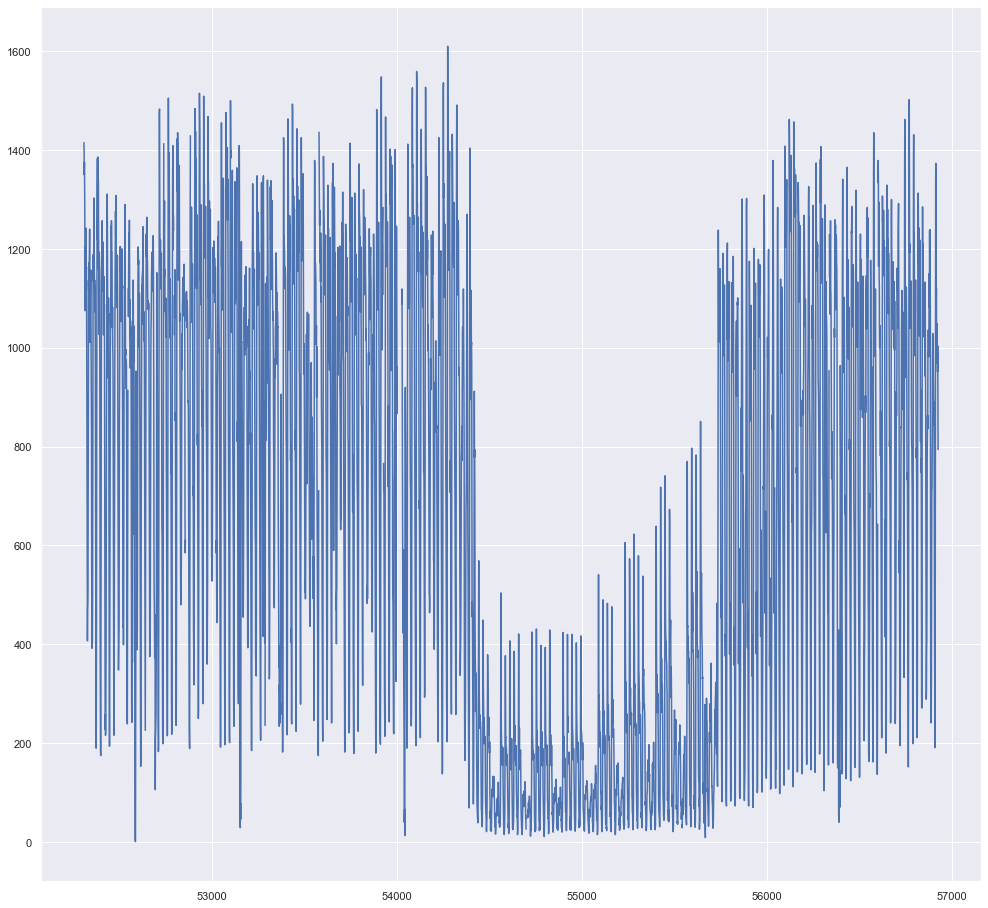

In [44]:
plt.figure(figsize=(15,15))
df[(df.Datetime >= '2019-12-20') & (df.Datetime < '2020-06-30')]['q_ce'].plot()

In [47]:
df = df.drop(['confinement_1', 'confinement_2', 'confinement_3'], axis=1)

<AxesSubplot:>

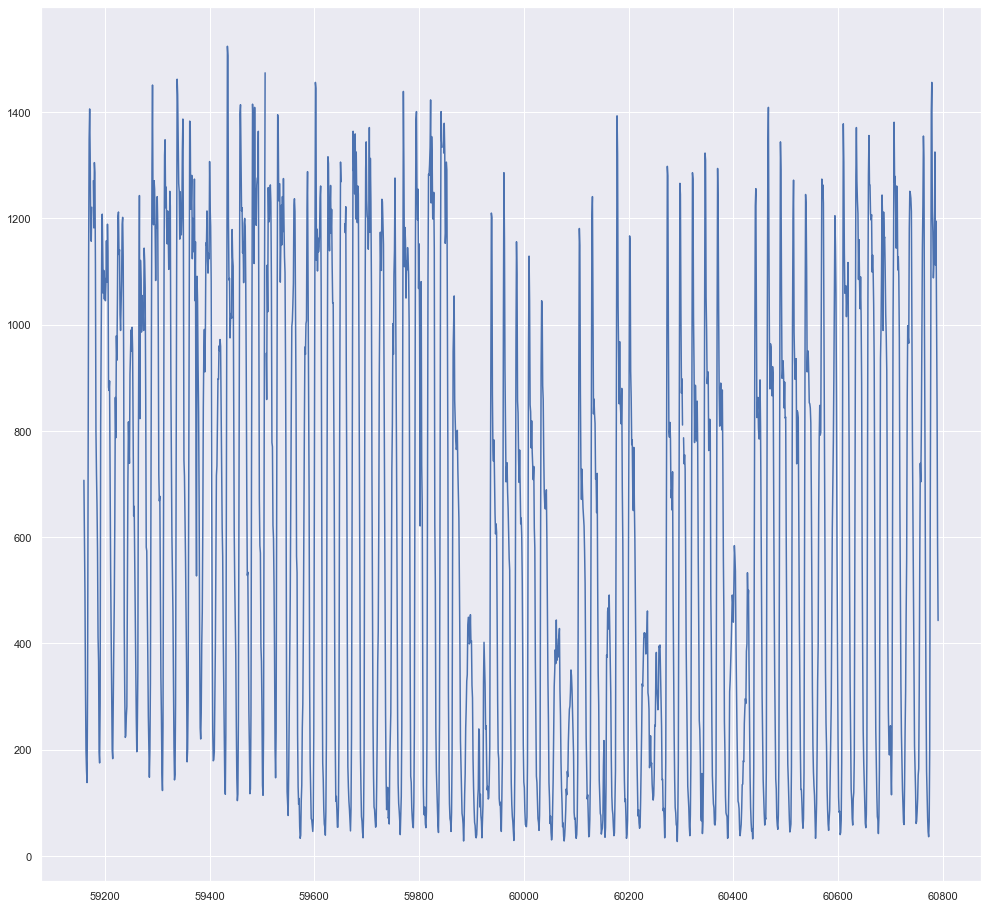

In [48]:
plt.figure(figsize=(15,15))
df[(df.Datetime >= '2020-10-01') & (df.Datetime < '2020-12-08')]['q_ce'].plot()

## Fill Intensite Greve

In [45]:
df[['intensite_greve']] = df[['intensite_greve']].fillna(value=np.float64(0))

In [49]:
df.to_csv('../Notebooks/data.csv', index=False)

# Third Step : Models

In [3]:
data = pd.read_csv('data.csv')
#data = data[data.Datetime < '2020-12-08'] # To modify as we will have more data
data.tail(48)

,Datetime,temp,templow,icon,baro,hum,rain,fog,thunder,snow,Année,Mois,Jour,Heure,Jour semaine,Férié,Vacances,curfew,intensite_greve,etat_barre_ce,q_ce,k_ce,etat_barre_lc,q_lc,k_lc,etat_barre_pv,q_pv,k_pv,year,sin_hour,cos_hour,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,quarter_1,quarter_2,quarter_3,quarter_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,sin_dayofyear,cos_dayofyear,sin_weekofyear,cos_weekofyear,dayofmonth_1,dayofmonth_2,dayofmonth_3,dayofmonth_4,dayofmonth_5,dayofmonth_6,dayofmonth_7,dayofmonth_8,dayofmonth_9,dayofmonth_10,dayofmonth_11,dayofmonth_12,dayofmonth_13,dayofmonth_14,dayofmonth_15,dayofmonth_16,dayofmonth_17,dayofmonth_18,dayofmonth_19,dayofmonth_20,dayofmonth_21,dayofmonth_22,dayofmonth_23,dayofmonth_24,dayofmonth_25,dayofmonth_26,dayofmonth_27,dayofmonth_28,dayofmonth_29,dayofmonth_30,dayofmonth_31,Wx,Wy,desc_Broken clouds.,desc_Chilly.,desc_Clear.,desc_Cloudy.,desc_Cool.,desc_Dense fog.,desc_Drizzle. Broken clouds.,desc_Drizzle. Fog.,desc_Drizzle. Low clouds.,desc_Drizzle. Mostly cloudy.,desc_Fog.,desc_Haze.,desc_Ice fog.,desc_Light fog.,desc_Light rain. Broken clouds.,desc_Light rain. Clear.,desc_Light rain. Cloudy.,desc_Light rain. Fog.,desc_Light rain. Low clouds.,desc_Light rain. More clouds than sun.,desc_Light rain. Mostly cloudy.,desc_Light rain. Overcast.,desc_Light rain. Partly cloudy.,desc_Light rain. Partly sunny.,desc_Light rain. Passing clouds.,desc_Light snow. Ice fog.,desc_Low clouds.,desc_Mild.,desc_More clouds than sun.,desc_Mostly cloudy.,desc_No weather data available,desc_Overcast.,desc_Partly cloudy.,desc_Partly sunny.,desc_Passing clouds.,desc_Rain. Fog.,desc_Scattered clouds.,desc_Sprinkles. Mostly cloudy.,desc_Sunny.,desc_Thunderstorms. Fog.,confinement
60984,2020-12-16 00:00:00,8.7,8.7,14.0,1020.0,84.0,0.0,0.0,0.0,0.0,2020.0,12.0,16.0,0.0,3.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,0.000000e+00,1.000000e+00,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.242567,0.970135,-0.234886,0.972023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-17.854160,-6.498383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
60985,2020-12-16 01:00:00,8.6,8.6,14.0,1020.0,85.0,0.0,0.0,0.0,0.0,2020.0,12.0,16.0,1.0,3.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2.588190e-01,9.659258e-01,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.242567,0.970135,-0.234886,0.972023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-19.733545,-7.182423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
60986,2020-12-16 02:00:00,8.4,8.4,14.0,1020.0,86.0,0.0,0.0,0.0,0.0,2020.0,12.0,16.0,2.0,3.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,5.000000e-01,8.660254e-01,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.242567,0.970135,-0.234886,0.972023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-17.964853,-6.185795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
60987,2020-12-16 03:00:00,8.2,8.2,14.0,1020.0,86.0,0.0,0.0,0.0,0.0,2020.0,12.0,16.0,3.0,3.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,7.071068e-01,7.071068e-01,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.242567,0.970135,-0.234886,0.972023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-15.974775,-5.814342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
60988,2020-12-16 04:00:00,7.9,7.9,14.0,1020.0,87.0,0.0,0.0,0.0,0.0,2020.0,12.0,16.0,4.0,3.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20

In [7]:
### Create for each street a dataframe
drop = ['etat_barre_ce', 'etat_barre_lc', 'templow', 'baro', 'etat_barre_pv', 'Année', 'Mois', 'Jour', 'Heure', 'Jour semaine']
target_ce = ['q_ce', 'k_ce']
target_lc = ['q_lc', 'k_lc']
target_pv = ['q_pv', 'k_pv']
all_ = drop + target_ce + target_lc + target_pv
features = [x for x in data.columns.tolist() if x not in all_]
df = copy.deepcopy(data)
df = df.drop(drop, axis=1)
df_ce = copy.deepcopy(df[features + target_ce])
df_lc = copy.deepcopy(df[features + target_lc])
df_pv = copy.deepcopy(df[features + target_pv])

In [8]:
df_ce = df_ce.drop(['temp',
 'icon',
 'hum',
 'rain',
 'fog',
 'thunder',
 'snow','desc_Broken clouds.', 'desc_Chilly.', 'desc_Clear.',
       'desc_Cloudy.', 'desc_Cool.', 'desc_Dense fog.',
       'desc_Drizzle. Broken clouds.', 'desc_Drizzle. Fog.',
       'desc_Drizzle. Low clouds.', 'desc_Drizzle. Mostly cloudy.',
       'desc_Fog.', 'desc_Haze.', 'desc_Ice fog.', 'desc_Light fog.',
       'desc_Light rain. Broken clouds.', 'desc_Light rain. Clear.',
       'desc_Light rain. Cloudy.', 'desc_Light rain. Fog.',
       'desc_Light rain. Low clouds.',
       'desc_Light rain. More clouds than sun.',
       'desc_Light rain. Mostly cloudy.', 'desc_Light rain. Overcast.',
       'desc_Light rain. Partly cloudy.',
       'desc_Light rain. Partly sunny.',
       'desc_Light rain. Passing clouds.', 'desc_Light snow. Ice fog.',
       'desc_Low clouds.', 'desc_Mild.', 'desc_More clouds than sun.',
       'desc_Mostly cloudy.', 'desc_No weather data available',
       'desc_Overcast.', 'desc_Partly cloudy.', 'desc_Partly sunny.',
       'desc_Passing clouds.', 'desc_Rain. Fog.',
       'desc_Scattered clouds.', 'desc_Sprinkles. Mostly cloudy.',
       'desc_Sunny.', 'desc_Thunderstorms. Fog.'], axis=1)

## Utils function

In [28]:
def rolling_custom(d, df, label):
    try:
        return df.loc[d - 168, label]
    except KeyError:
        return float('nan')

def create_train_test(df, date_min, date_max, label, prefix, start, dropna=True):
    if dropna:
        drop = df[label + '_' + prefix].notnull()
        train, test = df[(df.Datetime <= date_min) & drop & (df.Datetime >= start)].reset_index(drop=True), df[(df.Datetime >= date_min) & (df.Datetime <= date_max) & drop].reset_index(drop=True)
    x_train, y_train = train.drop(['Datetime', 'q_' + prefix, 'k_' + prefix], axis=1), train[['Datetime', label + '_' + prefix]]
    x_test, y_test = test.drop(['Datetime', 'q_' + prefix, 'k_' + prefix], axis=1), test[['Datetime', label + '_' + prefix]]
    return x_train, y_train, x_test, y_test

def train(models, X_train, y_train, X_test, y_test):
    model_trained = []
    for model in models:
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=40, 
                  verbose=False)
                 
        model_trained.append(model)
    return model_trained

def evaluate(models, X_test, y_test):
    rmse = []
    for model in models:
        rmse.append(np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    return rmse

def test_mean_average(y_pred1, y_pred2, y_test_date):
    y_test = y_test_date.drop(['Datetime'], axis=1).values
    return np.sqrt(mean_squared_error((y_pred1+y_pred2)/2, y_test))

def test_between_time(y_pred1, y_pred2, y_test_date):
    y_test_date['Datetime'] = pd.to_datetime(y_test_date['Datetime']) ## sanity check
    index_labels = y_test_date.reset_index().set_index('Datetime')
    index_day = index_labels.between_time('07:00', '22:00')['index'].tolist()
    #index_night = [idx for idx in index_labels['index'].tolist() if x not in index_day]
    final_prediction = []
    for i, preds in enumerate(zip(y_pred1, y_pred2)):
        if i in index_day:
            final_prediction.append(max(preds))
        else:
            final_prediction.append(min(preds))
    return np.array(final_prediction)
    

**Summary of the finetuning (hyperparameters, choose the best date where to start training, which features to add ..)**

For each street and each target (q or k) we will use what we call a stacking models (LGBM Regressor & XGB Regressor), the way we are going to stack these models will be further investigated (average of both predictions, take only one for some cases, take max during the day and min during the night ...)

**Champs Elysées**

*For q : *
- Use data from October 2020 and take only features that we extract in the previous section
- Xgboost : {learning_rate = 0.15, subsample=0.8, n_estimators=300}
- LGBM : {learning_rate = 0.15, subsample=0.8, n_estimators=300} 


*For k : *
- Use date from August 2020 and take only features that we extract in the previous section
- Xgboost : {n_estimators=300, subsample = 0.6, min_child_weight=5,  max_depth=4, random_state=27}
- LGBM : {n_estimators=300, subsample=0.8, num_leaves=25, learning_rate=0.15, random_state=27} 

**Convention**

*For q : *
- Use date from February 2020 and take only features that we extract in the previous section and add last week q value as feature
- Xgboost : {n_estimators=300, max_depth=4, min_child_weight=5, subsample=0.6, random_state=27}
- LGBM : {n_estimators=300, subsample=0.8, max_depth=4, colsample_bytree=0.8, subsample_freq=2, num_leaves=15,   random_state=27} 


*For k : *
- Use date from February 2020 and take only features that we extract in the previous section and add last week k value as feature
- Xgboost : {random_state = 27, colsample_bytree=0.7, max_depth=4, min_child_weight=5, subsample=0.8,n_estimators=300}
- LGBM : {subsample=0.8, subsample_freq=2, colsample_bytree=0.8, num_leaves=15, n_estimators=300, random_state=27} 

**Saint Peres**

*For q : *
- Use date from January 2020 and take only features that we extract in the previous section and add last week q value as feature
- Xgboost : {random_state = 27, max_depth=8, min_child_weight=5, n_estimators=300}
- LGBM : {colsample_bytree=0.8, subsample=0.8, num_leaves=25, n_estimators=300, subsample_freq=1, random_state=27} 


*For k : *
- Use date from January 2020 and take only features that we extract in the previous section and add both last week k value and q value as features
- Xgboost : {random_state = 27, max_depth=6, subsample=0.6, n_estimators=300}
- LGBM : {colsample_bytree=0.8, subsample=0.8, subsample_freq=1, n_estimators=300, random_state=27} 

**TODO(OMAR): TEST IF SCALING THE TARGET CAN IMPROVE THE PERFORMANCE FOR XGBOOST !!!!**
Tested on my draft for champs elysees, it's only make the predictions worse

## Champs Elysées

### Q

In [29]:
start = '2020-10-01'
models = [LGBMRegressor(n_estimators=300, subsample=0.8, learning_rate=0.15, random_state=27),
         XGBRegressor(n_estimators=300, subsample=0.8, random_state=27)]
# TO DO : Find the winning strategy for stacking by taking into account the last data

### Validation first period

In [45]:
X_train, y_train_date, X_test, y_test_date = create_train_test(df_ce, '2020-11-29', '2020-12-05', 'q', 'ce', '2020-10-01')
models = [LGBMRegressor(n_estimators=300, subsample=0.8, num_leaves=25, learning_rate=0.15, random_state=27),
         XGBRegressor(n_estimators=300, subsample=0.8, random_state=27)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[94.19623118550845, 97.87069509848422]

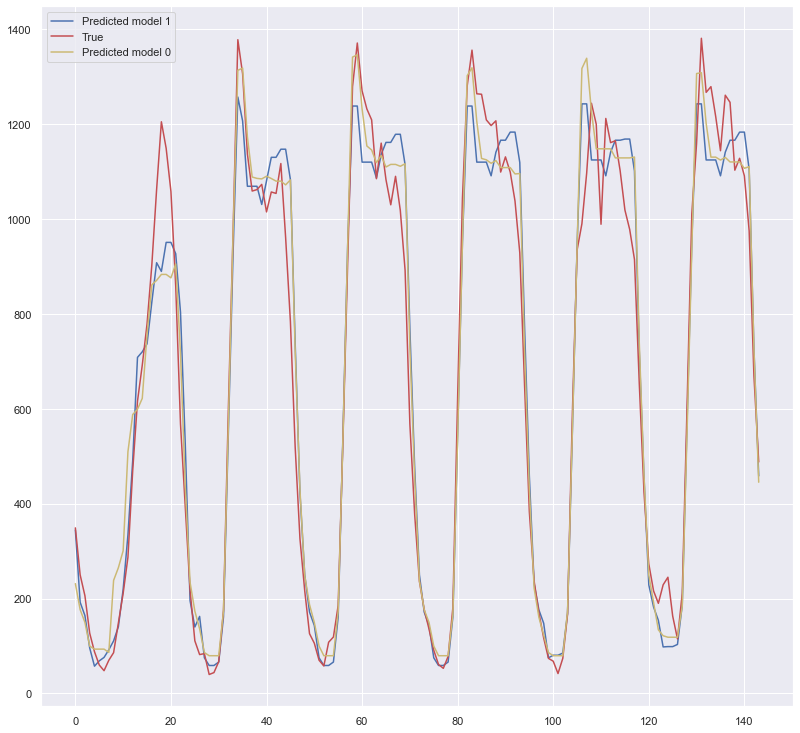

In [33]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
plt.figure(figsize=(12,12))
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted model 1", color='b')
plt.plot(np.arange(len(y_pred)), y_test.values, label="True", color='r')
plt.plot(np.arange(len(y_pred)), y_pred2, label="Predicted model 0", color='y')
plt.legend()
plt.show()

In [34]:
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged : {np.sqrt(mean_squared_error(preds, y_test.values))}")

RMSE after merged : 99.16721567883403


In [35]:
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged average : 92.66627107632303


In [46]:
date_min = '2020-11-29'
date_max = '2020-12-05'
#### compare with baseline
x = df_ce.copy()
x['back_q'] = pd.Series([rolling_custom(d, x, 'q_ce') for d in x.index])
y_baseline = x[(x.Datetime >= date_min) & (x.Datetime <= date_max)]['back_q'].values
np.sqrt(mean_squared_error(y_baseline, y_test.values))

216.23688142610845

### Second Period

In [40]:
X_train, y_train_date, X_test, y_test_date = create_train_test(df_ce, '2020-12-05', '2020-12-11', 'q', 'ce', '2020-10-01')
models = [LGBMRegressor(n_estimators=300, subsample=0.8, num_leaves=25, learning_rate=0.15, random_state=27),
         XGBRegressor(n_estimators=300, subsample=0.8, random_state=27)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[136.67081591170268, 136.47477202803213]

In [ ]:
df_lc['back_q'] = pd.Series([rolling_custom(d, df_lc, 'q_lc') for d in df_lc.index])

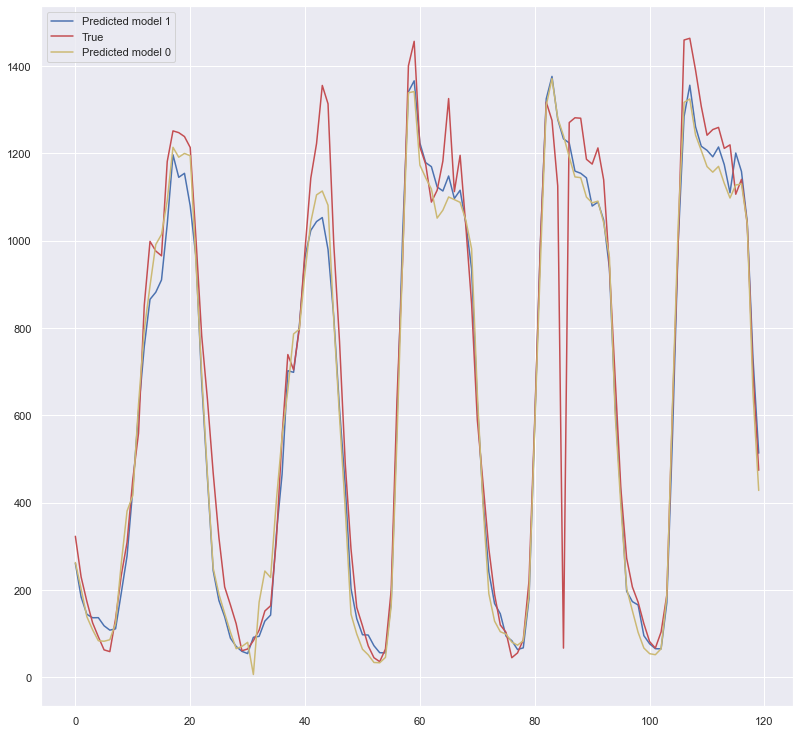

In [22]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
plt.figure(figsize=(12,12))
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted model 1", color='b')
plt.plot(np.arange(len(y_pred)), y_test.values, label="True", color='r')
plt.plot(np.arange(len(y_pred)), y_pred2, label="Predicted model 0", color='y')
plt.legend()
plt.show()

In [23]:
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged : {np.sqrt(mean_squared_error(preds, y_test.values))}")

RMSE after merged : 133.5141282925365


In [69]:
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged average : 134.75319936377687


**Winning :  Mean average strategy**

### K

In [ ]:
start = '2020-09-01'
models = [LGBMRegressor(learning_rate = 0.15, subsample=0.8, num_leaves=25, n_estimators=300, random_state=27),
         XGBRegressor(n_estimators=300, subsample = 0.6, min_child_weight=5,  max_depth=4, random_state=27)]
# TO DO : Find the winning strategy for stacking by taking into account the last data

### First period

In [47]:
X_train, y_train_date, X_test, y_test_date = create_train_test(df_ce, '2020-11-29', '2020-12-05', 'k', 'ce', '2020-08-01')
models = [LGBMRegressor(learning_rate = 0.15, subsample_freq=2, subsample=0.8, num_leaves=25, n_estimators=300, random_state=27),
         XGBRegressor(n_estimators=300, subsample = 0.6, min_child_weight=5,  max_depth=4, random_state=27)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[5.671325357505688, 5.24589250626891]

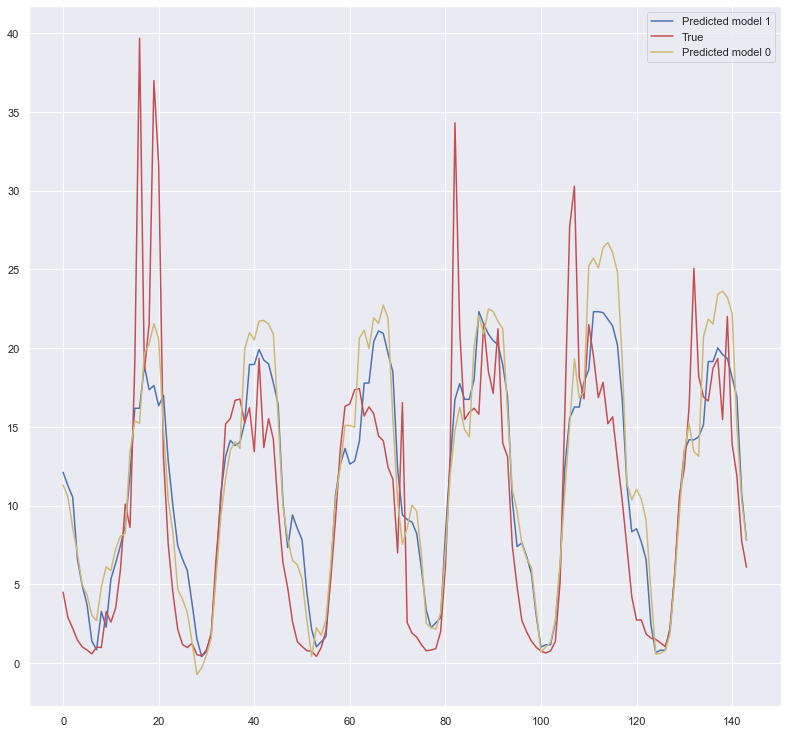

In [109]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
plt.figure(figsize=(12,12))
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted model 1", color='b')
plt.plot(np.arange(len(y_pred)), y_test.values, label="True", color='r')
plt.plot(np.arange(len(y_pred)), y_pred2, label="Predicted model 0", color='y')
plt.legend()
plt.show()

In [110]:
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged max/min : {np.sqrt(mean_squared_error(preds, y_test.values))}")

RMSE after merged max/min : 5.485036037857536


In [111]:
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged average : 5.356165906022908


In [48]:
date_min = '2020-11-29'
date_max = '2020-12-05'
#### compare with baseline
x = df_ce.copy()
x['back_k'] = pd.Series([rolling_custom(d, x, 'k_ce') for d in x.index])
y_baseline = x[(x.Datetime >= date_min) & (x.Datetime <= date_max)]['back_k'].values
np.sqrt(mean_squared_error(y_baseline, y_test.values))

6.864488444238913

### Second Period

In [106]:
X_train, y_train_date, X_test, y_test_date = create_train_test(df_ce, '2020-12-05', '2020-12-11', 'k', 'ce', '2020-08-01')
models = [LGBMRegressor(learning_rate = 0.15, subsample_freq=2, subsample=0.8, num_leaves=25, n_estimators=300, random_state=27),
         XGBRegressor(n_estimators=300, subsample = 0.6, min_child_weight=5,  max_depth=4, random_state=27)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[4.069298467397441, 4.315588188937567]

In [107]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged max/min : {np.sqrt(mean_squared_error(preds, y_test.values))}")
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged max/min : 3.9394252979073583
RMSE after merged average : 4.128220482927407


Well according to the period, we would rather merge them :)

**Winning : Merge min/max**

## Convention

### Q

In [ ]:
start = '2020-02-01'
models = [LGBMRegressor(n_estimators=300, subsample=0.8, max_depth=4, colsample_bytree=0.8, 
                        subsample_freq=2, num_leaves=15, random_state=27),
         XGBRegressor(n_estimators=300, max_depth=4, min_child_weight=5, subsample=0.6, random_state=27)]
# TO DO : Find the winning strategy for stacking by taking into account the last data

### Validation first period

In [49]:
df_lc['back_q'] = pd.Series([rolling_custom(d, df_lc, 'q_lc') for d in df_lc.index])
X_train, y_train_date, X_test, y_test_date = create_train_test(df_lc, '2020-11-29', '2020-12-05', 'q', 'lc', '2020-02-01')
models = [LGBMRegressor(n_estimators=300, subsample=0.8, max_depth=4, colsample_bytree=0.8, 
                        subsample_freq=2, num_leaves=15, random_state=27),
         XGBRegressor(n_estimators=300, max_depth=4, min_child_weight=5, subsample=0.6, random_state=27)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[55.24791086972733, 57.863527091789585]

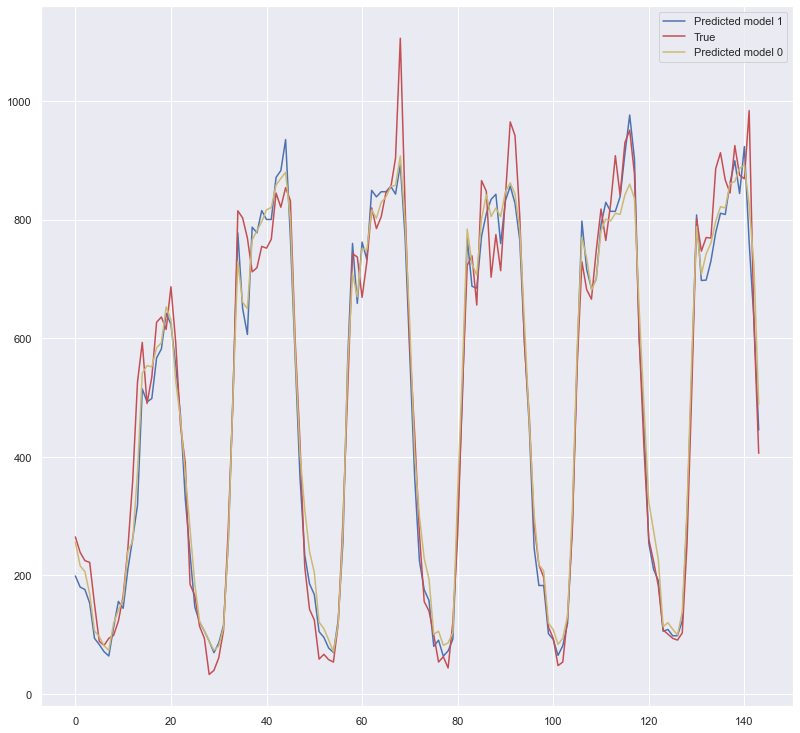

In [116]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
plt.figure(figsize=(12,12))
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted model 1", color='b')
plt.plot(np.arange(len(y_pred)), y_test.values, label="True", color='r')
plt.plot(np.arange(len(y_pred)), y_pred2, label="Predicted model 0", color='y')
plt.legend()
plt.show()

In [117]:
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged : {np.sqrt(mean_squared_error(preds, y_test.values))}")
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged : 53.55754619645707
RMSE after merged average : 54.177893461987644


In [50]:
date_min = '2020-11-29'
date_max = '2020-12-05'
#### compare with baseline
x = df_lc.copy()
x['back_q'] = pd.Series([rolling_custom(d, x, 'q_lc') for d in x.index])
y_baseline = x[(x.Datetime >= date_min) & (x.Datetime <= date_max)]['back_q'].values
np.sqrt(mean_squared_error(y_baseline, y_test.values))

93.91814550743405

### Second Period

In [118]:
X_train, y_train_date, X_test, y_test_date = create_train_test(df_lc, '2020-12-05', '2020-12-11', 'q', 'lc', '2020-02-01')
models = [LGBMRegressor(n_estimators=300, subsample=0.8, max_depth=4, colsample_bytree=0.8, 
                        subsample_freq=2, num_leaves=15, random_state=27),
         XGBRegressor(n_estimators=300, max_depth=4, min_child_weight=5, subsample=0.6, random_state=27)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[43.499333322368145, 44.434240517748265]

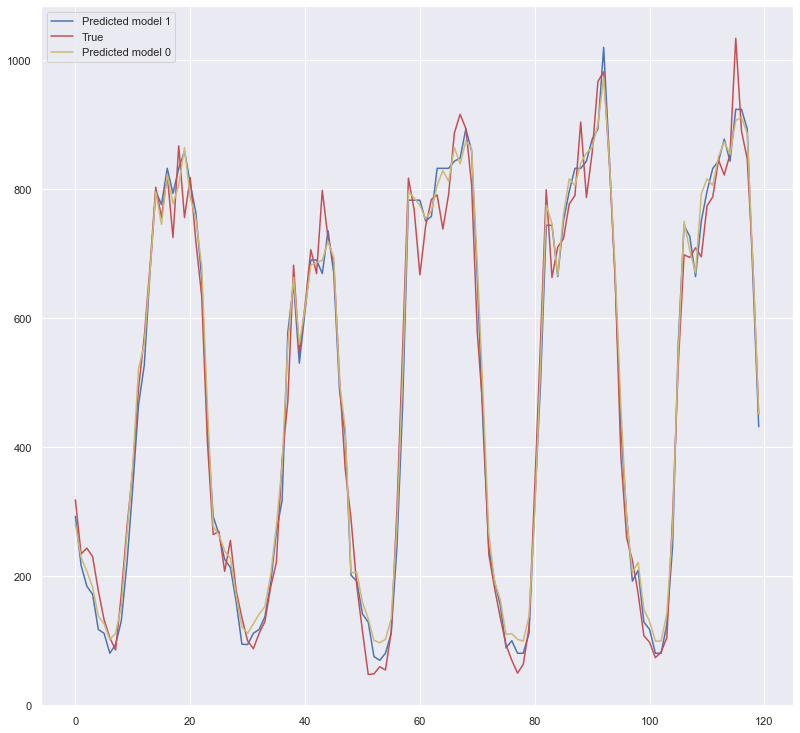

In [119]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
plt.figure(figsize=(12,12))
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted model 1", color='b')
plt.plot(np.arange(len(y_pred)), y_test.values, label="True", color='r')
plt.plot(np.arange(len(y_pred)), y_pred2, label="Predicted model 0", color='y')
plt.legend()
plt.show()

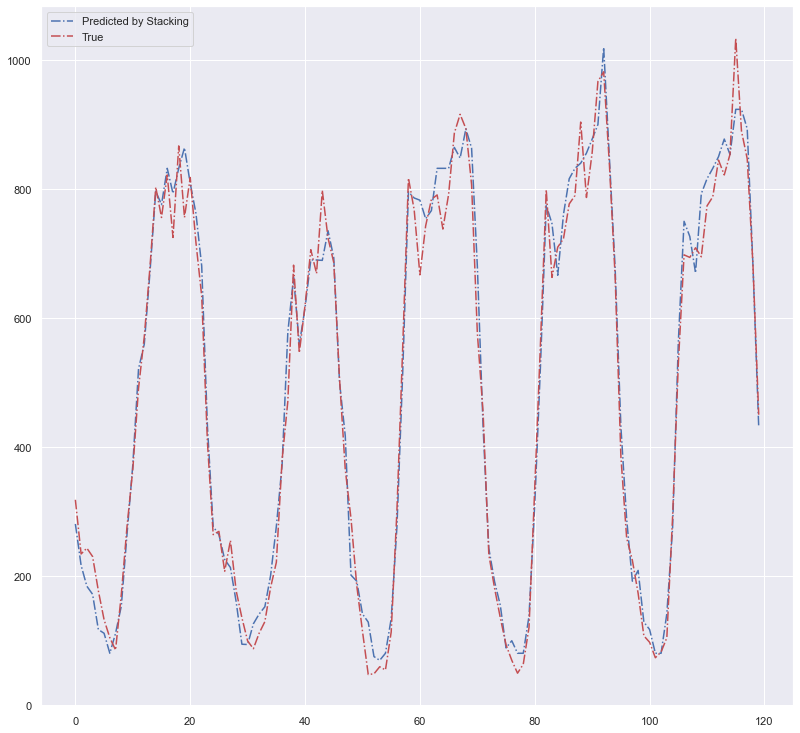

In [123]:
plt.figure(figsize=(12,12))
plt.plot(np.arange(len(y_pred)), preds, '-.', label="Predicted by Stacking", color='b')
plt.plot(np.arange(len(y_pred)), y_test.values, '-.', label="True", color='r')
plt.legend()
plt.show()

In [120]:
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged : {np.sqrt(mean_squared_error(preds, y_test.values))}")
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged : 43.159687806805536
RMSE after merged average : 42.71578918095658




**Winning :  Mean Merged strategy**

### K

In [ ]:
start = '2020-02-01'
models = [LGBMRegressor(subsample=0.8, subsample_freq=2, colsample_bytree=0.8, num_leaves=15, n_estimators=300, random_state=27),
         XGBRegressor(random_state = 27, colsample_bytree=0.7, max_depth=4, min_child_weight=5, subsample=0.8,
                      n_estimators=300)]
# TO DO : Find the winning strategy for stacking by taking into account the last data

### First period

In [51]:
df_lc = df_lc.drop(['back_q'], axis=1)
df_lc['back_k'] = pd.Series([rolling_custom(d, df_lc, 'k_lc') for d in df_lc.index])
X_train, y_train_date, X_test, y_test_date = create_train_test(df_lc, '2020-11-29', '2020-12-05', 'k', 'lc', '2020-02-01')
models = [LGBMRegressor(subsample=0.8, subsample_freq=2, colsample_bytree=0.8, num_leaves=15, n_estimators=300, random_state=27),
         XGBRegressor(random_state = 27, colsample_bytree=0.7, max_depth=4, min_child_weight=5, subsample=0.8,
                      n_estimators=300)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[3.1948075975664563, 3.0440912605247896]

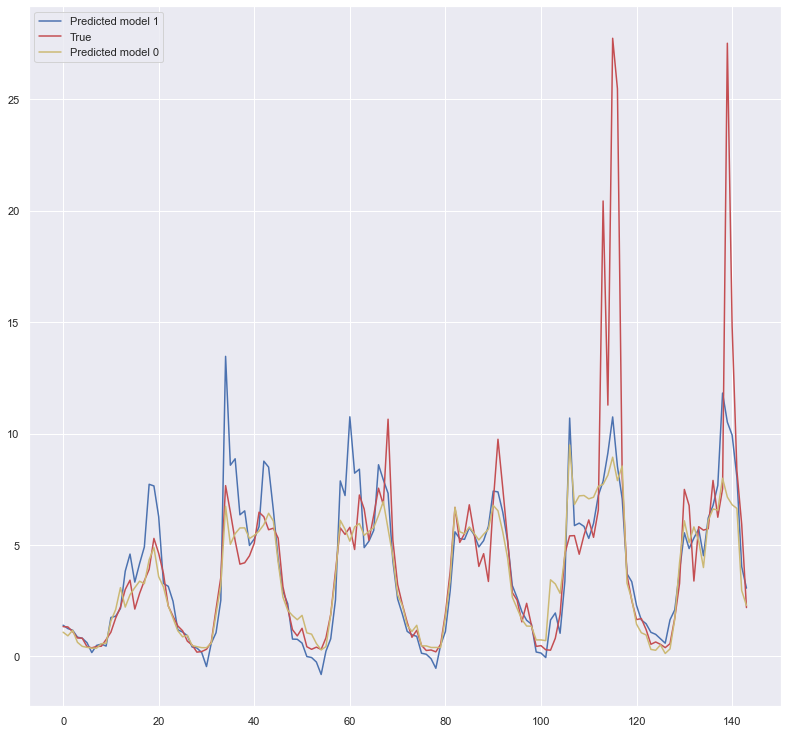

In [126]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
plt.figure(figsize=(12,12))
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted model 1", color='b')
plt.plot(np.arange(len(y_pred)), y_test.values, label="True", color='r')
plt.plot(np.arange(len(y_pred)), y_pred2, label="Predicted model 0", color='y')
plt.legend()
plt.show()

In [127]:
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged max/min : {np.sqrt(mean_squared_error(preds, y_test.values))}")

RMSE after merged max/min : 3.052775835561484


In [128]:
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged average : 3.043273555932294


In [53]:
date_min = '2020-11-29'
date_max = '2020-12-05'
#### compare with baseline
x = df_lc.copy()
x['back_k'] = pd.Series([rolling_custom(d, x, 'k_lc') for d in x.index])
y_baseline = x[(x.Datetime >= date_min) & (x.Datetime <= date_max)]['back_k'].values
np.sqrt(mean_squared_error(y_baseline, y_test.values))

3.7300270042501587

### Second Period

In [130]:
X_train, y_train_date, X_test, y_test_date = create_train_test(df_lc, '2020-12-05', '2020-12-11', 'k', 'lc', '2020-02-01')
models = [LGBMRegressor(subsample=0.8, subsample_freq=2, colsample_bytree=0.8, num_leaves=15, n_estimators=300, random_state=27),
         XGBRegressor(random_state = 27, colsample_bytree=0.7, max_depth=4, min_child_weight=5, subsample=0.8,
                      n_estimators=300)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[1.2705900526147893, 1.4238577702227737]

In [131]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged max/min : {np.sqrt(mean_squared_error(preds, y_test.values))}")
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged max/min : 1.4238403606410939
RMSE after merged average : 1.2984432659975307




**Winning : Mean average here**

## SaintP

### Q

In [ ]:
start = '2020-01-01'
models = [LGBMRegressor(colsample_bytree=0.8, subsample=0.8, num_leaves=25, n_estimators=300, subsample_freq=1, random_state=27),
         XGBRegressor(random_state = 27, max_depth=8, min_child_weight=5, n_estimators=300)]
# TO DO : Find the winning strategy for stacking by taking into account the last data

### Validation first period

In [54]:
df_pv['back_q'] = pd.Series([rolling_custom(d, df_pv, 'q_pv') for d in df_pv.index])
X_train, y_train_date, X_test, y_test_date = create_train_test(df_pv, '2020-11-29', '2020-12-05', 'q', 'pv', '2020-01-01')
models = [LGBMRegressor(colsample_bytree=0.8, subsample=0.8, num_leaves=25, n_estimators=300, subsample_freq=1,
                        random_state=27),
         XGBRegressor(random_state = 27, max_depth=8, min_child_weight=5, n_estimators=300)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[54.11728536481013, 51.85548830226653]

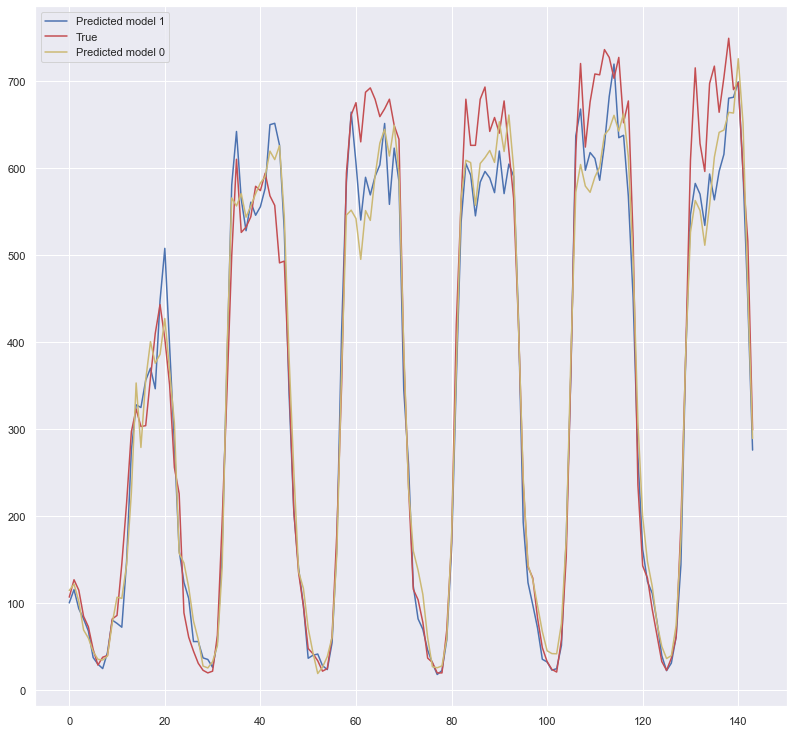

In [133]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
plt.figure(figsize=(12,12))
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted model 1", color='b')
plt.plot(np.arange(len(y_pred)), y_test.values, label="True", color='r')
plt.plot(np.arange(len(y_pred)), y_pred2, label="Predicted model 0", color='y')
plt.legend()
plt.show()

In [134]:
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged : {np.sqrt(mean_squared_error(preds, y_test.values))}")
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged : 46.21167536420836
RMSE after merged average : 50.684756657719994


In [55]:
date_min = '2020-11-29'
date_max = '2020-12-05'
#### compare with baseline
x = df_pv.copy()
x['back_q'] = pd.Series([rolling_custom(d, x, 'q_pv') for d in x.index])
y_baseline = x[(x.Datetime >= date_min) & (x.Datetime <= date_max)]['back_q'].values
np.sqrt(mean_squared_error(y_baseline, y_test.values))

105.81817476743356

Merge is better :o

### Second Period

In [140]:
df_pv['back_q'] = pd.Series([rolling_custom(d, df_pv, 'q_pv') for d in df_pv.index])
X_train, y_train_date, X_test, y_test_date = create_train_test(df_pv, '2020-12-05', '2020-12-11', 'q', 'pv', '2020-01-01')
models = [LGBMRegressor(colsample_bytree=0.8, subsample=0.8, num_leaves=25, n_estimators=300,  subsample_freq=1, random_state=27),
         XGBRegressor(random_state = 27, max_depth=8, min_child_weight=5, n_estimators=300)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[46.234000501118935, 50.19974480380205]

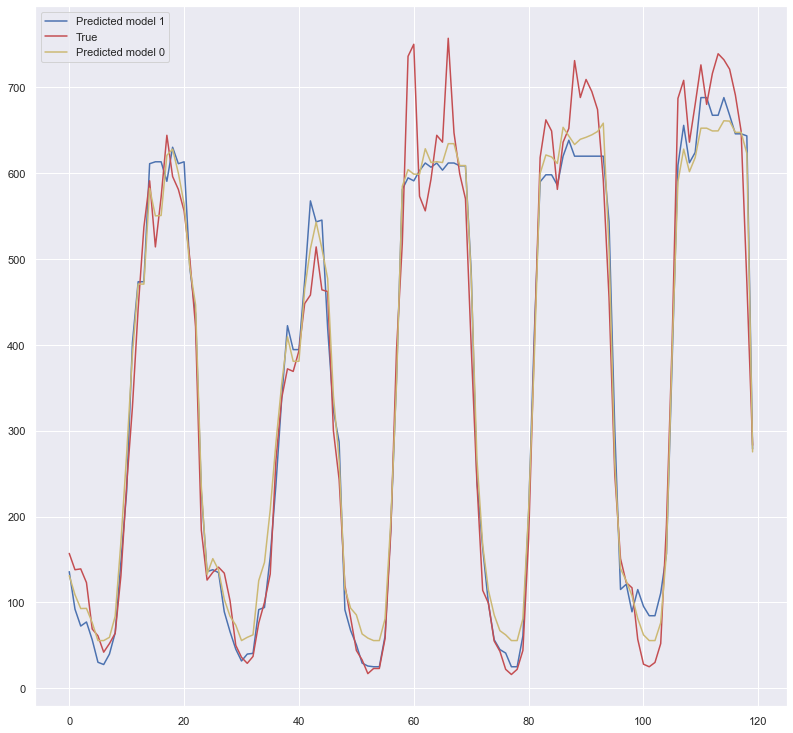

In [141]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
plt.figure(figsize=(12,12))
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted model 1", color='b')
plt.plot(np.arange(len(y_pred)), y_test.values, label="True", color='r')
plt.plot(np.arange(len(y_pred)), y_pred2, label="Predicted model 0", color='y')
plt.legend()
plt.show()

In [142]:
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged : {np.sqrt(mean_squared_error(preds, y_test.values))}")
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged : 47.960777300554824
RMSE after merged average : 46.60421301454576


**Winning :  merge both of them with max/min strategy**

### K

In [ ]:
start = '2020-01-01'
models = [LGBMRegressor(colsample_bytree=0.8, subsample=0.8, subsample_freq=1, n_estimators=300, random_state=27),
         XGBRegressor(random_state = 27, max_depth=6, subsample=0.6, n_estimators=300)]
# TO DO : Find the winning strategy for stacking by taking into account the last data

### First period

In [56]:
df_pv['back_k'] = pd.Series([rolling_custom(d, df_pv, 'k_pv') for d in df_pv.index])
X_train, y_train_date, X_test, y_test_date = create_train_test(df_pv, '2020-11-29', '2020-12-05', 'k', 'pv', '2020-01-01')
models = [LGBMRegressor(colsample_bytree=0.8, subsample=0.8, subsample_freq=1, n_estimators=300, random_state=27),
         XGBRegressor(random_state = 27, max_depth=6, subsample=0.6, n_estimators=300)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[1.8329716954736888, 2.2562962431286353]

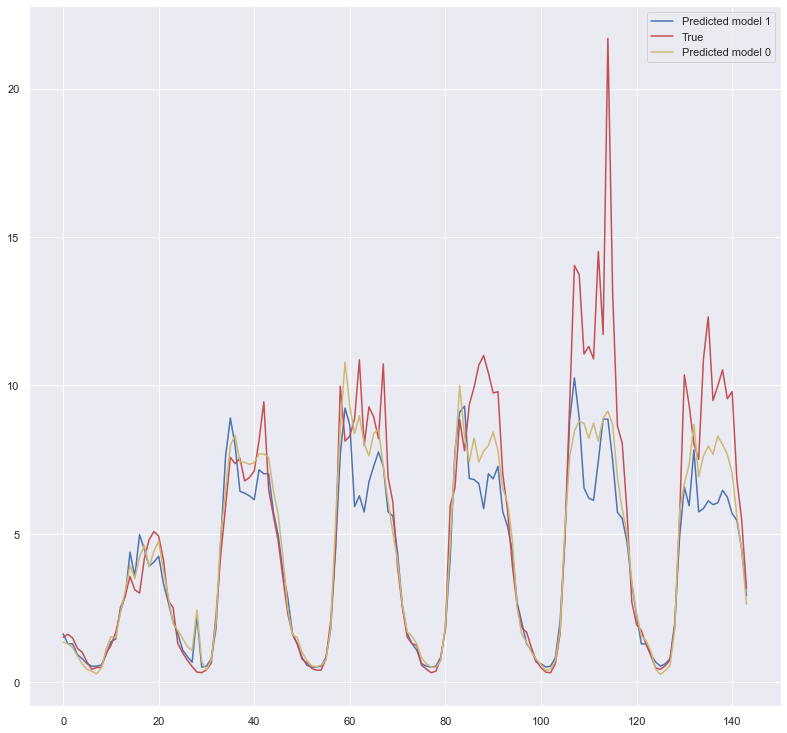

In [144]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
plt.figure(figsize=(12,12))
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted model 1", color='b')
plt.plot(np.arange(len(y_pred)), y_test.values, label="True", color='r')
plt.plot(np.arange(len(y_pred)), y_pred2, label="Predicted model 0", color='y')
plt.legend()
plt.show()

In [145]:
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged max/min : {np.sqrt(mean_squared_error(preds, y_test.values))}")

RMSE after merged max/min : 1.8072717279600405


In [146]:
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged average : 2.01193676191361


In [57]:
date_min = '2020-11-29'
date_max = '2020-12-05'
#### compare with baseline
x = df_pv.copy()
x['back_k'] = pd.Series([rolling_custom(d, x, 'k_pv') for d in x.index])
y_baseline = x[(x.Datetime >= date_min) & (x.Datetime <= date_max)]['back_k'].values
np.sqrt(mean_squared_error(y_baseline, y_test.values))

2.540885576345627

### Second Period

In [147]:
X_train, y_train_date, X_test, y_test_date = create_train_test(df_pv, '2020-12-05', '2020-12-11', 'k', 'pv', '2020-01-01')
models = [LGBMRegressor(colsample_bytree=0.8, subsample=0.8, subsample_freq=1, n_estimators=300, random_state=27),
         XGBRegressor(random_state = 27, max_depth=6, subsample=0.6, n_estimators=300)]
y_train, y_test = y_train_date.drop(['Datetime'], axis=1), y_test_date.drop(['Datetime'], axis=1)
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[1.5710784839143395, 1.2026652061625032]

In [148]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
preds = test_between_time(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged max/min : {np.sqrt(mean_squared_error(preds, y_test.values))}")
score = test_mean_average(y_pred, y_pred2, y_test_date)
print(f"RMSE after merged average : {score}")

RMSE after merged max/min : 1.220054311305834
RMSE after merged average : 1.3220162589609592


Well according to both period, the best strategy is to use the merge min max !

**Winning : the best strategy is to use the merge min max**

# Make predictions

In [1]:
# TO DO !